In [1]:
import zipfile
import os


In [2]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [3]:
from zipfile import ZipFile

In [4]:
zip_file_path = '/content/drive/MyDrive/Skin_disease_data.zip'  # Path to your uploaded zip file

In [5]:
# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')
    print(f'Extracted {zip_file_path} to /content/')


Extracted /content/drive/MyDrive/Skin_disease_data.zip to /content/


In [6]:
# List the contents of the extracted directory
data_dir = '/content/Skin_disease_data'
print(os.listdir(data_dir))

# Check the subdirectories
eczema_path = os.path.join(data_dir, '1. Eczema')
psoriasis_path = os.path.join(data_dir, '7. Psoriasis')
print(f"Eczema directory exists: {os.path.exists(eczema_path)}")
print(f"Psoriasis directory exists: {os.path.exists(psoriasis_path)}")

['1. Eczema', '7. Psoriasis']
Eczema directory exists: True
Psoriasis directory exists: True


In [7]:
# Cell 1: Imports and setup
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [8]:
# Suppress warnings
import warnings
warnings.filterwarnings(action="ignore")


In [9]:
# Cell 2: Load the data
# Assuming the extracted folder is named 'Skin_disease_data'
data_dir = '/content/Skin_disease_data'
Eczema_dir = os.path.join(data_dir, '1. Eczema')
Psoriasis_dir = os.path.join(data_dir, '7. Psoriasis')


In [10]:
filepaths = []
labels = []
dict_list = [Eczema_dir, Psoriasis_dir]
class_labels = ['Eczema', 'Psoriasis']

for i, j in enumerate(dict_list):
    flist = os.listdir(j)
    for f in flist:
        fpath = os.path.join(j, f)
        filepaths.append(fpath)
        labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
skin_data = pd.concat([Fseries, Lseries], axis=1)
skin_df = pd.DataFrame(skin_data)
print(skin_df.head())
print(skin_df["labels"].value_counts())


                                           filepaths  labels
0  /content/Skin_disease_data/1. Eczema/t-eczema-...  Eczema
1  /content/Skin_disease_data/1. Eczema/t-pomphol...  Eczema
2  /content/Skin_disease_data/1. Eczema/t-03Eczem...  Eczema
3      /content/Skin_disease_data/1. Eczema/0_36.jpg  Eczema
4  /content/Skin_disease_data/1. Eczema/t-prurigo...  Eczema
labels
Psoriasis    2055
Eczema       1677
Name: count, dtype: int64


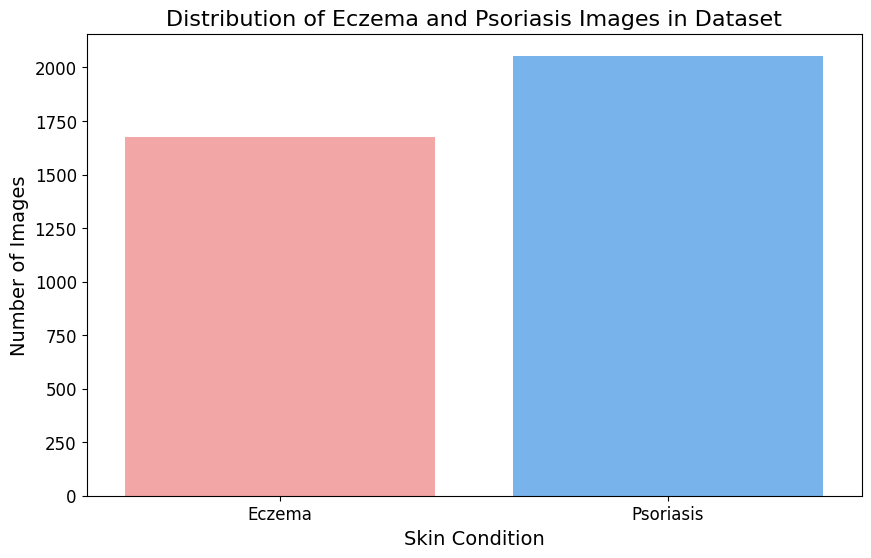

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming skin_df is already created from the provided code
# Visualize the distribution of Eczema and Psoriasis images
plt.figure(figsize=(10, 6))
sns.countplot(data=skin_df, x='labels', palette=['#ff9999', '#66b3ff'])
plt.xlabel('Skin Condition', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)
plt.title('Distribution of Eczema and Psoriasis Images in Dataset', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


In [18]:
# Total data split: 10% testing, 90% for training and validation
train_val_images, test_images = train_test_split(skin_df, test_size=0.15, random_state=42)

# Split the 90% data into 70% training and 20% validation
train_set, val_set = train_test_split(train_val_images, test_size=0.2, random_state=42)

In [19]:
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)

(2537, 2)
(560, 2)
(635, 2)


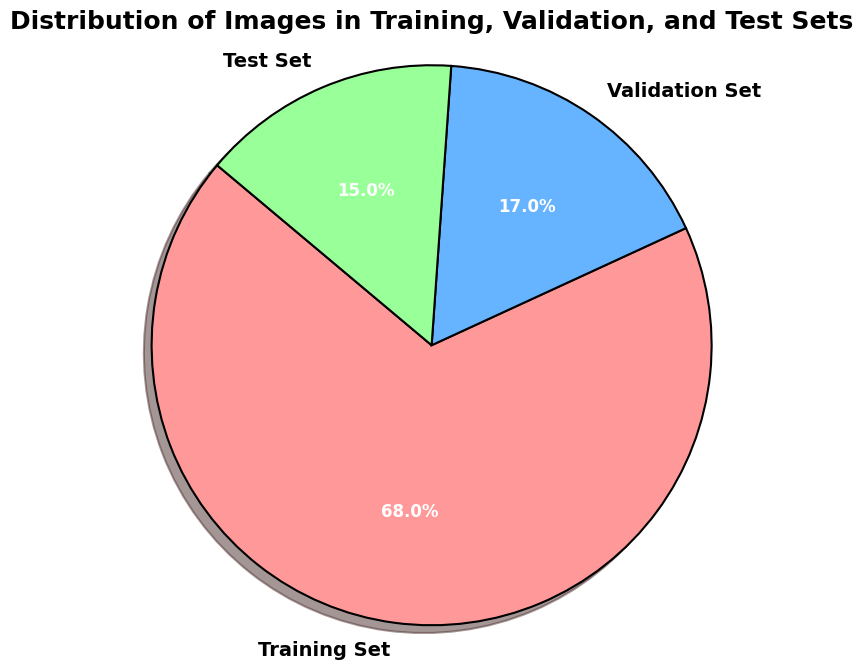

In [20]:
import matplotlib.pyplot as plt

# Data for pie chart
sets = ['Training Set', 'Validation Set', 'Test Set']
counts = [len(train_set), len(val_set), len(test_images)]
colors = ['#ff9999','#66b3ff','#99ff99']

plt.figure(figsize=(10, 8))
wedges, texts, autotexts = plt.pie(
    counts,
    labels=sets,
    colors=colors,
    autopct='%1.1f%%',
    startangle=140,
    shadow=True,
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5}
)

# Beautify the pie chart
for text in texts:
    text.set_fontsize(14)
    text.set_fontweight('bold')

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(12)
    autotext.set_fontweight('bold')

plt.title('Distribution of Images in Training, Validation, and Test Sets', fontsize=18, fontweight='bold')
plt.axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle.
plt.show()


In [21]:
# No data augmentation
image_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)

train = image_gen.flow_from_dataframe(
    dataframe=train_set, x_col="filepaths", y_col="labels",
    target_size=(299, 299),  # InceptionV3 requires 299x299 images
    color_mode='rgb',
    class_mode="categorical",  # used for Sequential Model
    batch_size=32,
    shuffle=True  # shuffle data to increase randomness
)

test = image_gen.flow_from_dataframe(
    dataframe=test_images, x_col="filepaths", y_col="labels",
    target_size=(299, 299),
    color_mode='rgb',
    class_mode="categorical",
    batch_size=32,
    shuffle=False
)

val = image_gen.flow_from_dataframe(
    dataframe=val_set, x_col="filepaths", y_col="labels",
    target_size=(299, 299),
    color_mode='rgb',
    class_mode="categorical",
    batch_size=32,
    shuffle=False
)


Found 2537 validated image filenames belonging to 2 classes.
Found 560 validated image filenames belonging to 2 classes.
Found 635 validated image filenames belonging to 2 classes.


In [22]:
classes = list(train.class_indices.keys())
print(classes)

['Eczema', 'Psoriasis']


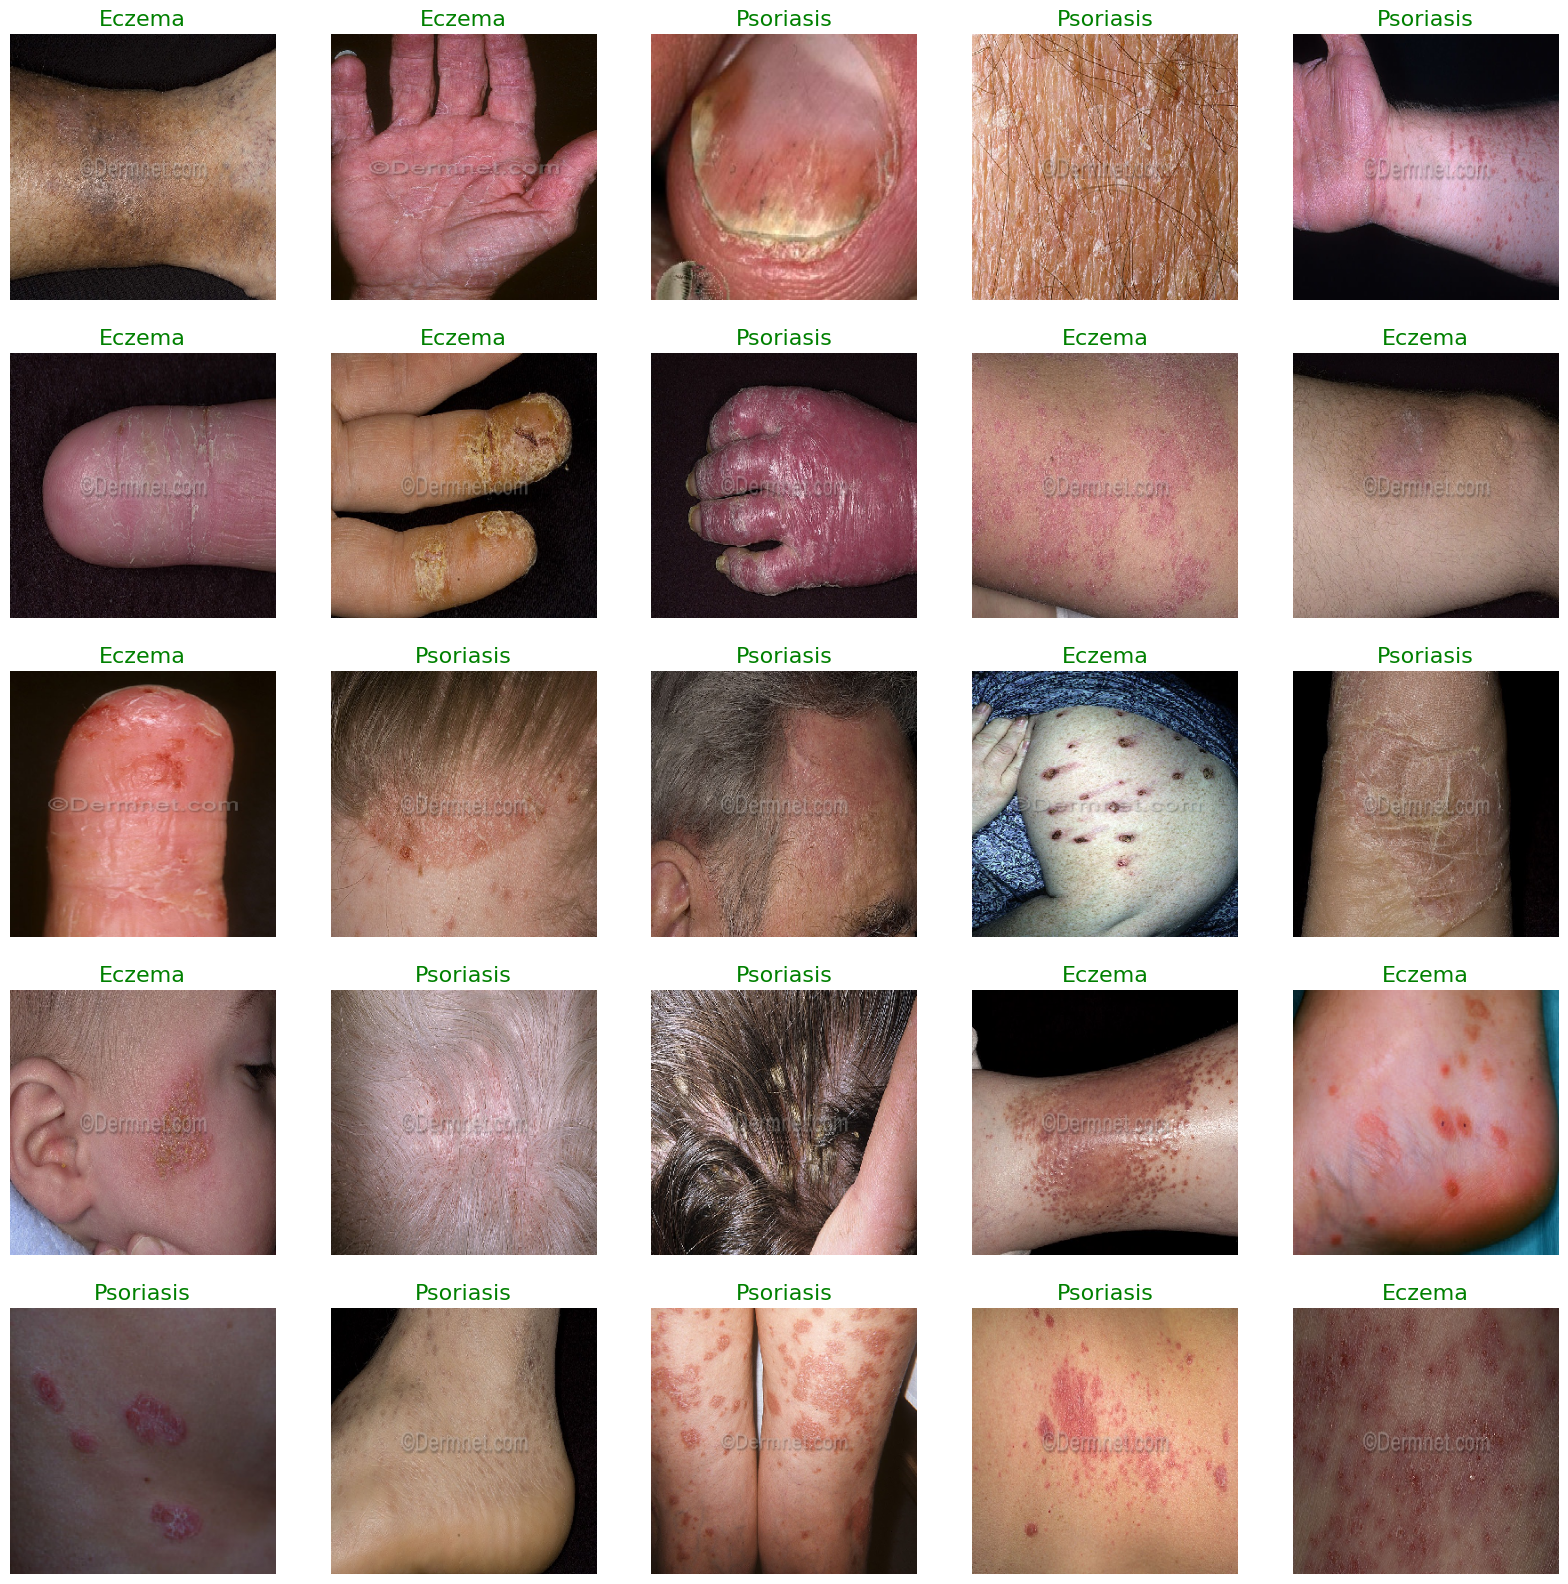

In [24]:
def show_Skin_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels = next(image_gen)  # get a sample batch from the generator
    plt.figure(figsize=(20, 20))
    length = len(labels)
    if length < 25:
        r = length
    else:
        r = 25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image = (images[i] + 1) / 2  # scale images between 0 and 1
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color="green", fontsize=16)
        plt.axis('off')
    plt.show()
show_Skin_images(train)

In [38]:
# Load the InceptionV3 model pre-trained on ImageNet
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Unfreeze the top layers of the base model
for layer in base_model.layers[-120:]:  # Unfreeze more layers
    layer.trainable = True

# Build a new model on top of the pre-trained base using the optimal hyperparameters
def build_transfer_learning_model(num_classes):
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(640, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),  # Increased dropout rate
        Dense(640, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),  # Increased dropout rate
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0002479277711879142),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


num_classes = len(classes)
# Build the transfer learning model
transfer_learning_model = build_transfer_learning_model(num_classes)

# Learning rate schedule callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model
history_transfer_learning = transfer_learning_model.fit(train, epochs=20, validation_data=val, callbacks=[reduce_lr])

# Evaluate on the test set
test_loss, test_accuracy = transfer_learning_model.evaluate(test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
















Epoch 1/20
80/80 [==============================] - 48s 239ms/step - loss: 0.9554 - accuracy: 0.6287 - val_loss: 1.6364 - val_accuracy: 0.5339 - lr: 2.4793e-04
Epoch 2/20
80/80 [==============================] - 18s 218ms/step - loss: 0.7350 - accuracy: 0.6910 - val_loss: 0.6964 - val_accuracy: 0.5843 - lr: 2.4793e-04
Epoch 3/20
80/80 [==============================] - 17s 217ms/step - loss: 0.5515 - accuracy: 0.7753 - val_loss: 0.6578 - val_accuracy: 0.6583 - lr: 2.4793e-04
Epoch 4/20
80/80 [==============================] - 17s 216ms/step - loss: 0.3624 - accuracy: 0.8514 - val_loss: 0.6931 - val_accuracy: 0.7354 - lr: 2.4793e-04
Epoch 5/20
80/80 [==============================] - 18s 218ms/step - loss: 0.2672 - accuracy: 0.8948 - val_loss: 0.8071 - val_accuracy: 0.7496 - lr: 2.4793e-04
Epoch 6/20
80/80 [==============================] - 18s 218ms/step - loss: 0.2049 - accuracy: 0.9251 - val_loss: 0.6200 - val_accuracy: 0.7874 - lr: 2.4793e-04
Epoch 7/20
80/80 [======================

In [44]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
pred2 = transfer_learning_model.predict(test)
y_pred = np.argmax(pred2, axis=1)
y_true = test.labels
print(classification_report(y_true, y_pred))
accuracy = accuracy_score(y_true, y_pred) * 100
print("Accuracy of the Model: {:.1f}%".format(accuracy))

18/18 [==============================] - 3s 138ms/step
              precision    recall  f1-score   support

           0       0.89      0.82      0.85       278
           1       0.83      0.90      0.87       282

    accuracy                           0.86       560
   macro avg       0.86      0.86      0.86       560
weighted avg       0.86      0.86      0.86       560

Accuracy of the Model: 85.9%


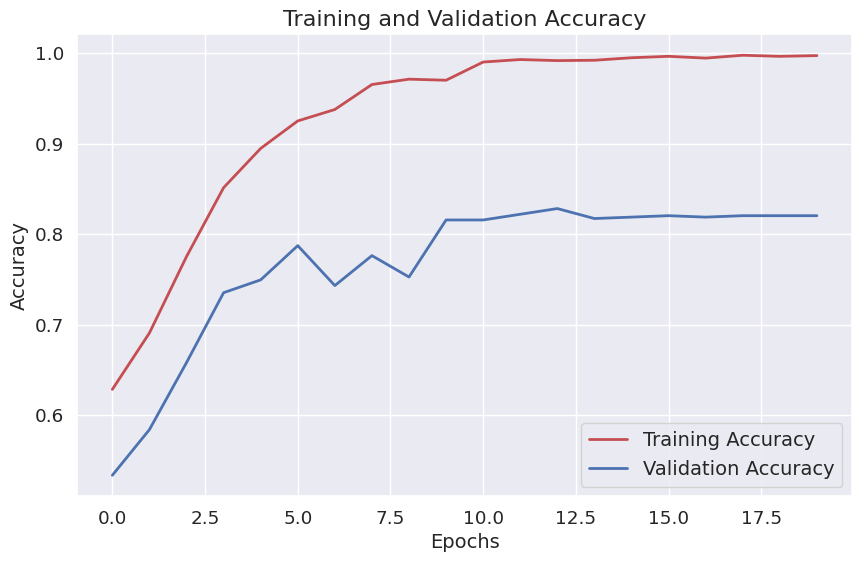

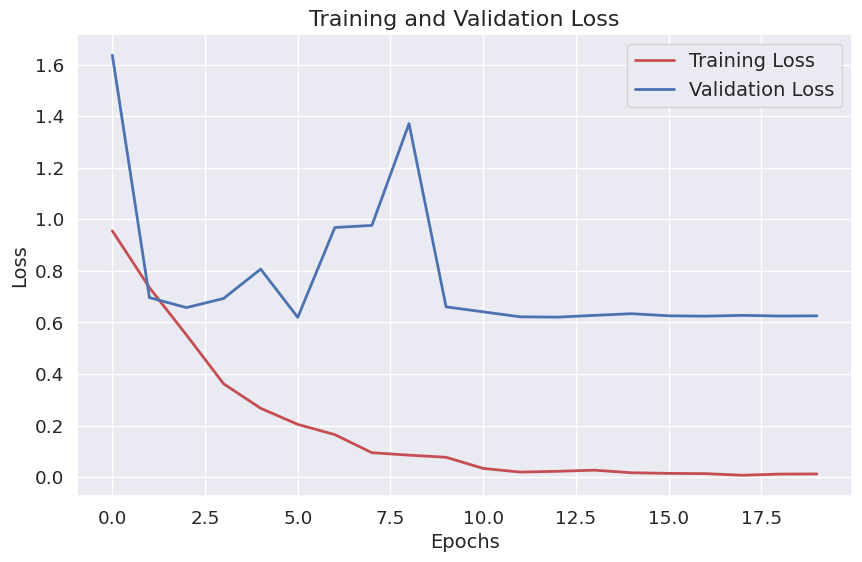

In [62]:
# Plot training & validation accuracy and loss values
history = history_transfer_learning

# Accuracy Curves
plt.figure(figsize=[10, 6])
plt.plot(history.history['accuracy'], 'r', linewidth=2.0)
plt.plot(history.history['val_accuracy'], 'b', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Training and Validation Accuracy', fontsize=16)
plt.grid(True)
plt.show()

# Loss Curves
plt.figure(figsize=[10, 6])
plt.plot(history.history['loss'], 'r', linewidth=2.0)
plt.plot(history.history['val_loss'], 'b', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training and Validation Loss', fontsize=16)
plt.grid(True)
plt.show()

18/18 [==============================] - 2s 132ms/step


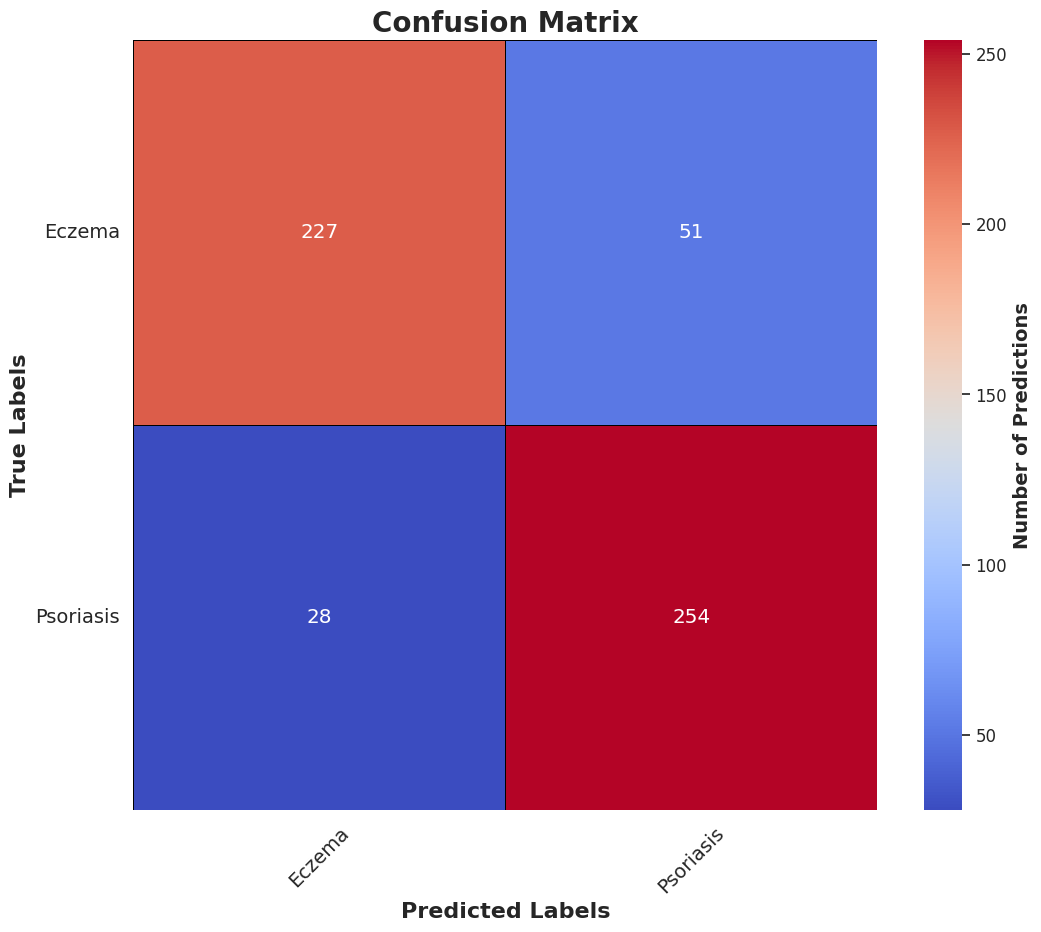

In [53]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get true labels and predicted labels
true_labels = test.classes
predictions = transfer_learning_model.predict(test)
predicted_labels = np.argmax(predictions, axis=1)

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Define the labels based on your classes
classes = list(test.class_indices.keys())

# Create a DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=classes, columns=classes)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.set(font_scale=1.2)  # Adjust to taste
heatmap = sns.heatmap(cm_df, annot=True, cmap='coolwarm', fmt='g', linewidths=.5, cbar=True, linecolor='black')

# Add labels, title, and adjust font styles
plt.title('Confusion Matrix', fontsize=20, fontweight='bold')
plt.xlabel('Predicted Labels', fontsize=16, fontweight='bold')
plt.ylabel('True Labels', fontsize=16, fontweight='bold')
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14, rotation=0)

# Add a color bar legend
cbar = heatmap.collections[0].colorbar
cbar.set_label('Number of Predictions', fontsize=14, fontweight='bold')
cbar.ax.tick_params(labelsize=12)

plt.show()



First image to predict


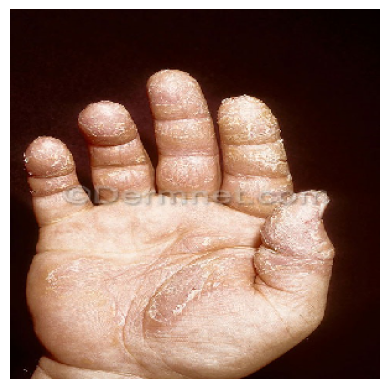

Actual label: Eczema
1/1 [==============================] - 0s 40ms/step
Predicted label: Eczema


In [57]:
import numpy as np
import matplotlib.pyplot as plt

# Additional code to predict the first image from the test set
for image_batch, label_batch in test:
    first_image = image_batch[0]
    first_label = np.argmax(label_batch[0])

    print("First image to predict")
    plt.imshow((first_image + 1) / 2)  # Scale image between 0 and 1
    plt.axis('off')  # Disable grid lines
    plt.show()
    print("Actual label:", classes[first_label])

    batch_prediction = transfer_learning_model.predict(image_batch)
    print("Predicted label:", classes[np.argmax(batch_prediction[0])])

    break


1/1 [==============================] - 0s 31ms/step


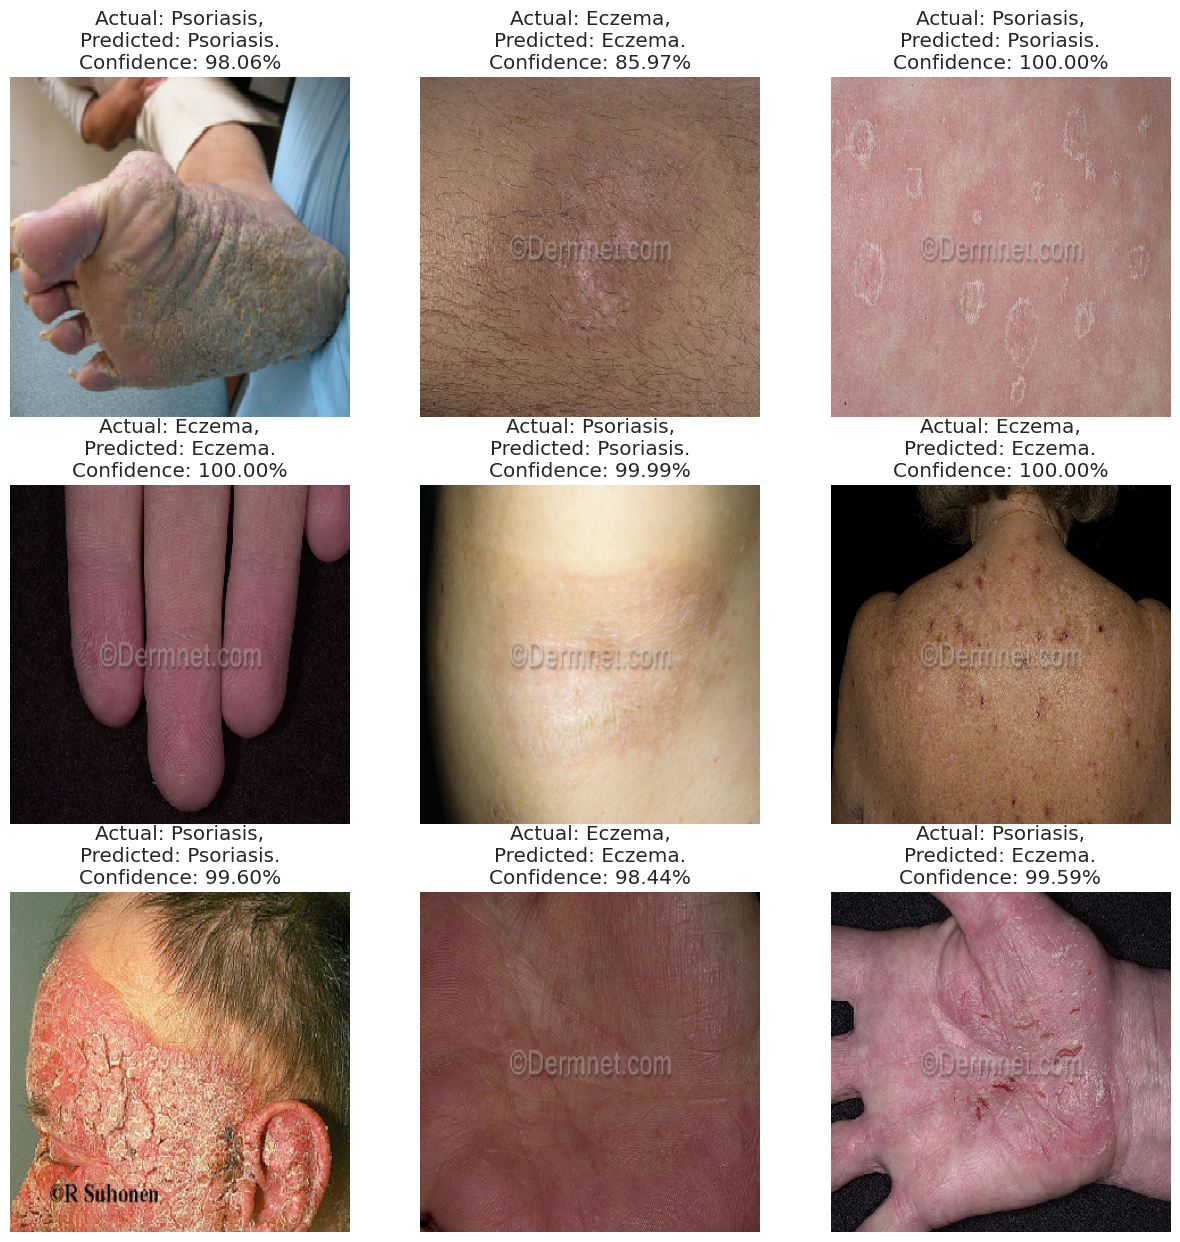

In [60]:
import numpy as np
import matplotlib.pyplot as plt

# Define the class names
class_names = ['Eczema', 'Psoriasis']  # class names

# Function to predict and get confidence
def predict(model, image):
    image = np.expand_dims(image, axis=0)  # Expand dimensions to fit the model input
    predictions = model.predict(image)
    predicted_class = np.argmax(predictions)
    confidence = np.max(predictions) * 100
    return class_names[predicted_class], confidence

# Display predictions and confidence on a few test images
plt.figure(figsize=(15, 15))
for images, labels in test:  # test should be your test generator
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow((images[i] + 1) / 2)  # Scale image between 0 and 1 if necessary

        predicted_class, confidence = predict(transfer_learning_model, images[i])
        actual_class = class_names[np.argmax(labels[i])]

        plt.title(f"Actual: {actual_class},\nPredicted: {predicted_class}.\nConfidence: {confidence:.2f}%")

        plt.axis("off")
    break
plt.show()


In [63]:
# Save the model with the specified name as .h5
model_save_path = '/content/drive/MyDrive/final_inception_model.h5'
transfer_learning_model.save(model_save_path, save_format='h5')
print(f"Model saved to {model_save_path}")


Model saved to /content/drive/MyDrive/final_inception_model.h5
